In [2]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    return np.hstack((mfcc, mel))

# directories in which datset is present
RAVDESS_DIR = 'ravdess_dataset'
TESS_DIR = 'tess_dataset'

# Function to extract emotion from RAVDESS filename
def extract_ravdess_emotion(filename):
    return filename.split('-')[2]

# Function to extract emotion from TESS filename
def extract_tess_emotion(filename):
    emotion_str = filename.split('_')[-1].split('.')[0]
    return emotion_str

# Function to process dataset directory
def process_directory(directory, emotion_map, extract_emotion_func):
    features, labels = [], []
    for subdir, _, files in os.walk(directory):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                emotion_key = extract_emotion_func(file)
                if emotion_key in emotion_map:
                    emotion = emotion_map[emotion_key]
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(emotion)
                else:
                    print(f"Warning: Emotion '{emotion_key}' not found in emotion map.")
    return np.array(features), np.array(labels)

# Define emotion mappings for both datasets
ravdess_emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

tess_emotion_map = {
    'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
    'ps': 4, 'sad': 5, 'neutral': 6
}

# Create a reverse mapping for TESS emotions(to make the wors back to integer)
reverse_tess_emotion_map = {v: k for k, v in tess_emotion_map.items()}

# Process RAVDESS and TESS datasets
X_ravdess, y_ravdess = process_directory(RAVDESS_DIR, ravdess_emotion_map, extract_emotion_func=extract_ravdess_emotion)
X_tess, y_tess = process_directory(TESS_DIR, tess_emotion_map, extract_emotion_func=extract_tess_emotion)

# Convert y_tess back to emotion names
y_tess_emotion_names = [reverse_tess_emotion_map[label] for label in y_tess]

# Combine datasets
X = np.vstack((X_ravdess, X_tess))
y = np.hstack((y_ravdess, y_tess_emotion_names))

0it [00:00, ?it/s]
100%|██████████| 104/104 [00:05<00:00, 19.14it/s]
0it [00:00, ?it/s]
100%|██████████| 200/200 [00:04<00:00, 48.23it/s]


In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Dataset and DataLoader
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = EmotionDataset(X_train, y_train)
test_dataset = EmotionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

input_dim = X.shape[1]
num_classes = len(label_encoder.classes_)

model = EmotionClassifier(input_dim, num_classes)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy*100,"%")


Accuracy: 77.73549000951475 %


In [9]:
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in data_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    return accuracy_score(all_labels, all_preds), classification_report(all_labels, all_preds, target_names=label_encoder.classes_), confusion_matrix(all_labels, all_preds)

# Evaluate on the training set
train_accuracy, train_classification_report,train_cm= evaluate(model, train_loader)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:")
print(train_classification_report)

# Evaluate on the test set
test_accuracy, test_classification_report,test_cm = evaluate(model, test_loader)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(test_classification_report)

Training Accuracy: 0.8521780528445608
Training Classification Report:
              precision    recall  f1-score   support

       angry       0.99      0.92      0.95       621
        calm       0.50      0.94      0.66       301
     disgust       0.92      0.81      0.87       473
        fear       1.00      1.00      1.00       320
     fearful       0.84      0.61      0.71       301
       happy       0.90      0.92      0.91       621
     neutral       0.93      0.75      0.83       470
          ps       1.00      1.00      1.00       320
         sad       0.87      0.78      0.82       621
   surprised       0.50      0.71      0.59       153

    accuracy                           0.85      4201
   macro avg       0.85      0.84      0.83      4201
weighted avg       0.88      0.85      0.86      4201

Test Accuracy: 0.7773549000951475
Test Classification Report:
              precision    recall  f1-score   support

       angry       0.89      0.80      0.84       155


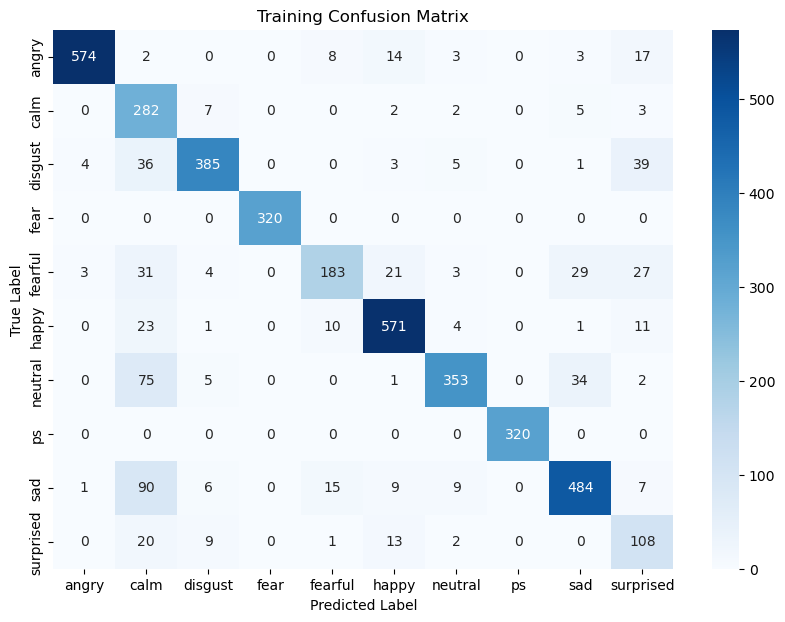

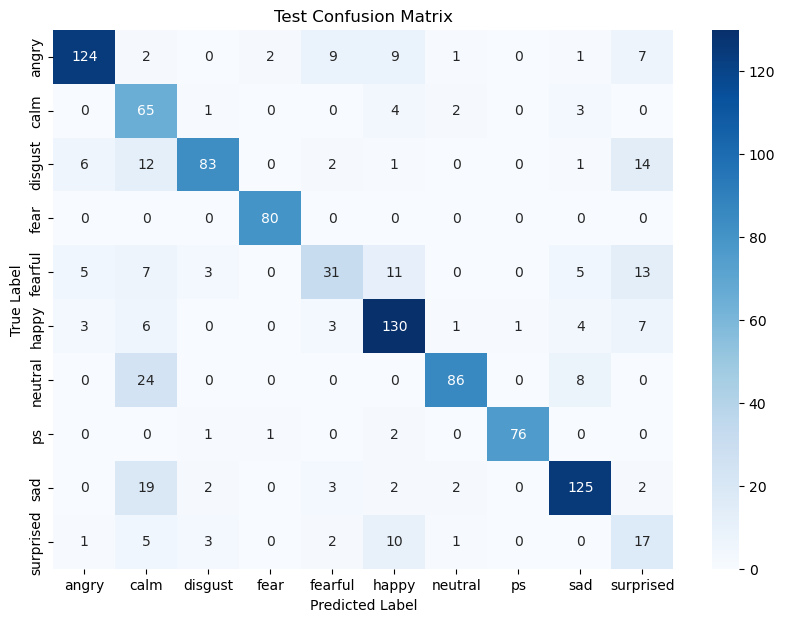

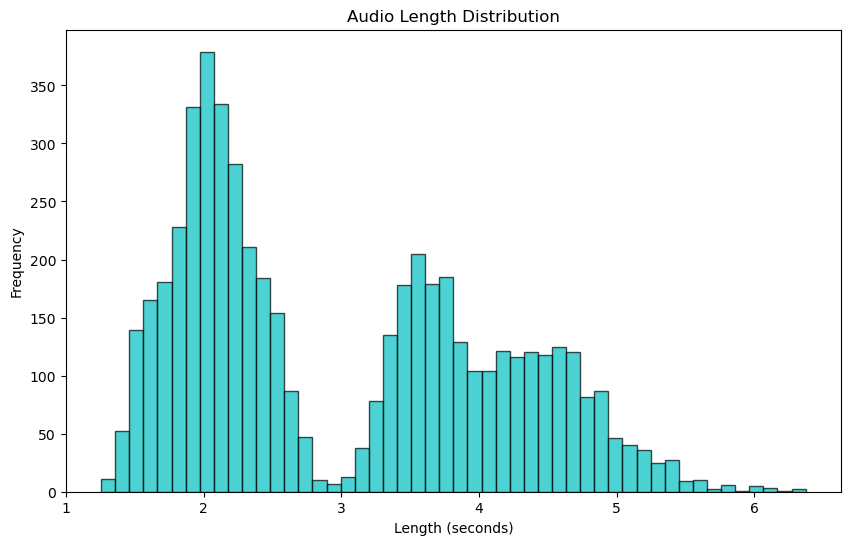

In [11]:
#plots for confusion matrix of train and test and of the data 

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(train_cm, label_encoder.classes_, title='Training Confusion Matrix')
plot_confusion_matrix(test_cm, label_encoder.classes_, title='Test Confusion Matrix')
def plot_audio_length_distribution(directories):
    lengths = []
    for directory in directories:
        for subdir, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.wav'):
                    file_path = os.path.join(subdir, file)
                    y, sr = librosa.load(file_path, sr=None)
                    lengths.append(len(y) / sr)
    
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, color='c', edgecolor='k', alpha=0.7)
    plt.title('Audio Length Distribution')
    plt.xlabel('Length (seconds)')
    plt.ylabel('Frequency')
    plt.show()

def plot_feature_distribution(features, labels):
    plt.figure(figsize=(14, 8))
    for i in range(features.shape[1]):
        plt.subplot(4, 4, i + 1)
        for label in np.unique(labels):
            sns.kdeplot(features[labels == label, i], label=label_encoder.inverse_transform([label])[0])
        plt.title(f'Feature {i+1}')
    plt.tight_layout()
    plt.show()
plot_audio_length_distribution([RAVDESS_DIR, TESS_DIR])

In [11]:
torch.save(model.state_dict(), 'emotion_classifier.pth')


In [ ]:
#code to predict emotion of an external audio (optional part)
import pickle
scaler = StandardScaler().fit(X_train)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

model = EmotionClassifier(input_dim, num_classes)
model.load_state_dict(torch.load('emotion_classifier.pth'))
model.eval()

# Define the label encoder with the same labels used during training
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['angry', 'disgust', 'fear', 'happy', 'ps', 'sad', 'neutral', 'calm', 'surprised']))

# Function to extract MFCC and MEL spectrogram features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    return np.hstack((mfcc, mel))

# Function to predict emotion from an audio file
def predict_emotion(file_path):
    features = extract_features(file_path)
    features = scaler.transform([features])  # Normalize the features
    features = torch.tensor(features, dtype=torch.float32)
    
    with torch.no_grad():
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
    
    emotion = label_encoder.inverse_transform(predicted.numpy())[0]
    return emotion

# Function to load the scaler used during training
def load_scaler(scaler_path):
    import pickle
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    return scaler

# Load the scaler used during training
scaler = load_scaler('scaler.pkl')

# Get user input for the audio file path
file_path = input("Enter the path to the audio file: ")

# Predict the emotion
predicted_emotion = predict_emotion(file_path)
print(f"The predicted emotion is: {predicted_emotion}")
